In [1]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
path = os.getcwd()
covid = pd.read_csv(path + '/covid_19_death.csv',low_memory=False)
covid.head()


,MSOA code,Total_Death
0,E02000001,11.0
1,E02000002,42.0
2,E02000003,25.0
3,E02000004,24.0
4,E02000005,22.0


In [3]:
msoa  = pd.read_csv(path + '/MSOA_tidy_economy.csv',encoding = 'gb2312')

In [4]:
msoa.head()

,MSOA_Code,MSOA_Name,Unemployment_Rate,Median_Income,Economically_active(%),Income_Deprivation,No_cars_household (%)
0,E02000001,City of London 001,3.8,46788.0,78.8,9.9,69.4
1,E02000002,Barking and Dagenham 001,11.8,27059.0,65.3,27.5,37.6
2,E02000003,Barking and Dagenham 002,9.1,36835.0,70.5,21.2,31.2
3,E02000004,Barking and Dagenham 003,9.3,39668.0,71.8,21.3,24.0
4,E02000005,Barking and Dagenham 004,9.7,29156.0,68.3,25.3,33.9


In [5]:
print(msoa.shape)

(984, 7)


In [6]:
msoa_covid = pd.merge(msoa, covid, left_on='MSOA_Code', right_on='MSOA code', how='inner')
print(msoa_covid.shape)
msoa_covid

(984, 9)


,MSOA_Code,MSOA_Name,Unemployment_Rate,Median_Income,Economically_active(%),Income_Deprivation,No_cars_household (%),MSOA code,Total_Death
0,E02000001,City of London 001,3.8,46788.0,78.8,9.9,69.4,E02000001,11.0
1,E02000002,Barking and Dagenham 001,11.8,27059.0,65.3,27.5,37.6,E02000002,42.0
2,E02000003,Barking and Dagenham 002,9.1,36835.0,70.5,21.2,31.2,E02000003,25.0
3,E02000004,Barking and Dagenham 003,9.3,39668.0,71.8,21.3,24.0,E02000004,24.0
4,E02000005,Barking and Dagenham 004,9.7,29156.0,68.3,25.3,33.9,E02000005,22.0
...,...,...,...,...,...,...,...,...,...
979,E02000980,Westminster 021,7.1,36808.0,71.2,27.4,67.1,E02000980,15.0
980,E02000981,Westminster 022,5.2,51738.0,77.5,18.4,60.8,E02000981,5.0
981,E02000982,Westminster 023,7.2,34920.0,69.4,20.5,64.8,E02000982,21.0
982,E02000983,Westminster 024,6.2,35968.0,70.9,17.4,65.5,E02000983,11.0


In [7]:
msoa_covid.drop(msoa_covid[msoa_covid.MSOA_Code.isna()].index.values, axis=0, inplace=True)
print(msoa_covid.shape) 

(983, 9)


In [8]:
msoa_covid.drop(["MSOA code","MSOA_Code","MSOA_Name"],axis=1, inplace=True)

In [9]:
msoa_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unemployment_Rate       983 non-null    float64
 1   Median_Income           983 non-null    float64
 2   Economically_active(%)  983 non-null    float64
 3   Income_Deprivation      983 non-null    float64
 4   No_cars_household (%)   983 non-null    float64
 5   Total_Death             983 non-null    float64
dtypes: float64(6)
memory usage: 53.8 KB


In [10]:
msoa_covid = pd.get_dummies(msoa_covid)

In [11]:
corr = msoa_covid.corr()
corr


,Unemployment_Rate,Median_Income,Economically_active(%),Income_Deprivation,No_cars_household (%),Total_Death
Unemployment_Rate,1.000000,-0.778019,-0.615517,0.755541,0.535451,0.188549
Median_Income,-0.778019,1.000000,0.522776,-0.565299,-0.276452,-0.304855
Economically_active(%),-0.615517,0.522776,1.000000,-0.352657,-0.160181,-0.307167
Income_Deprivation,0.755541,-0.565299,-0.352657,1.000000,0.780988,0.013438
No_cars_household (%),0.535451,-0.276452,-0.160181,0.780988,1.000000,-0.227662
Total_Death,0.188549,-0.304855,-0.307167,0.013438,-0.227662,1.000000


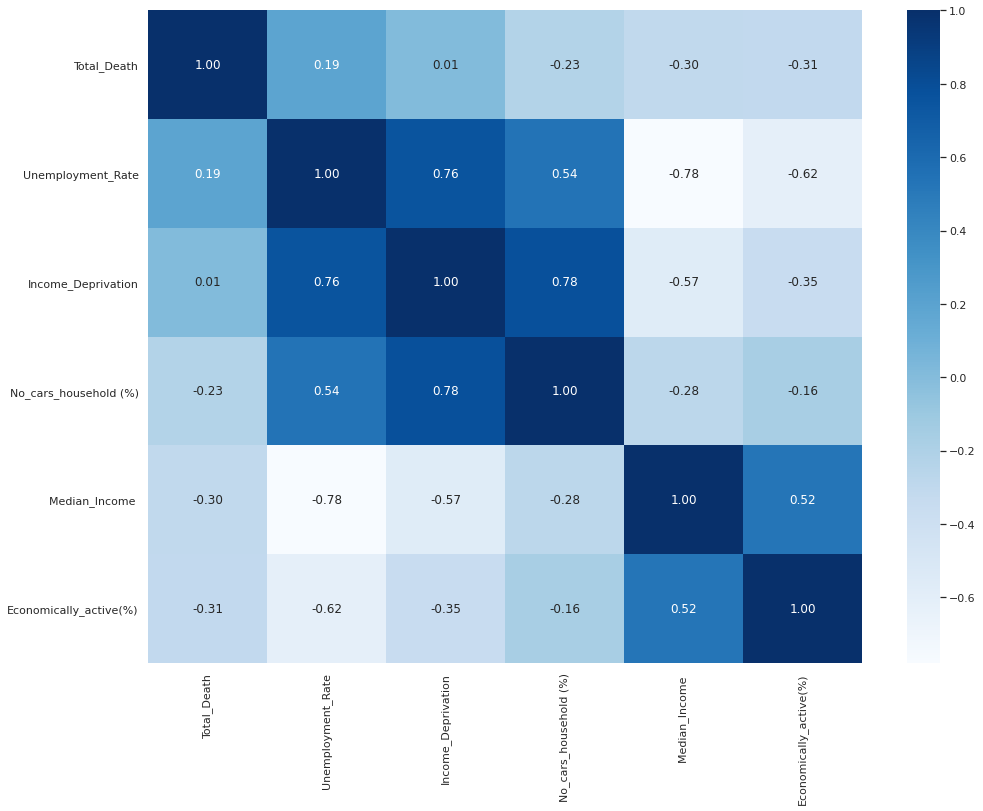

In [12]:
k=15
cols = corr.nlargest(k, 'Total_Death')['Total_Death'].index
heat = np.corrcoef(msoa_covid[cols].values.T)
sns.set(font_scale=1.0)
plt.subplots(figsize=(16, 12))
hm = sns.heatmap(heat, cbar=True, annot=True, square=False, fmt='.2f', annot_kws={'size': 12}, cmap = "Blues", yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [13]:
#help(sns.heatmap)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):

    while True:

        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        vif_df = vif_df.drop('const')
        

        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df

In [15]:
mosa_gdf_census1_new = drop_column_using_vif_(msoa_covid.drop('Total_Death', axis=1))

Dropping: Unemployment_Rate


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
regression = sm.OLS(endog=msoa_covid[['Total_Death']],exog=sm.add_constant(mosa_gdf_census1_new)).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total_Death   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     76.19
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           2.91e-56
Time:                        17:34:42   Log-Likelihood:                -3411.4
No. Observations:                 983   AIC:                             6833.
Df Residuals:                     978   BIC:                             6857.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     56.6487      4.092     13.844      0.000      48.619      64.679
Median_Income             -0.0002   3.14e-05     -5.992      0.000      -0.000      -0.000
Economically_active(%)    -0.3579      0.059     -6.073      0.000      -0.474      -0.242
Income_Deprivation         0.1138      0.038      3.000      0.003       0.039       0.188
No_cars_household (%)     -0.2358      0.025     -9.581      0.000      -0.284      -0.187
==============================================================================
Omnibus:                      134.500   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.160
Skew:                           0.924   Prob(JB):                     3.82e-46
Kurtosis:                       4.299   Cond. No.                     6.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# residual analysis
#sns.set()
#import warnings # ignore warning
#warnings.filterwarnings("ignore")
#fig = plt.figure(figsize=(15,8))
#fig = sm.graphics.plot_regress_exog(regression,"Density", fig =fig)

### log total death

In [18]:
msoa_covid1 = msoa_covid
msoa_covid1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unemployment_Rate       983 non-null    float64
 1   Median_Income           983 non-null    float64
 2   Economically_active(%)  983 non-null    float64
 3   Income_Deprivation      983 non-null    float64
 4   No_cars_household (%)   983 non-null    float64
 5   Total_Death             983 non-null    float64
dtypes: float64(6)
memory usage: 53.8 KB


In [19]:
#没有log前drop掉P值高的数据

In [20]:
import numpy as np
msoa_covid1['lntotal'] = np.log(msoa_covid1.Total_Death)
msoa_covid1

,Unemployment_Rate,Median_Income,Economically_active(%),Income_Deprivation,No_cars_household (%),Total_Death,lntotal
0,3.8,46788.0,78.8,9.9,69.4,11.0,2.397895
1,11.8,27059.0,65.3,27.5,37.6,42.0,3.737670
2,9.1,36835.0,70.5,21.2,31.2,25.0,3.218876
3,9.3,39668.0,71.8,21.3,24.0,24.0,3.178054
4,9.7,29156.0,68.3,25.3,33.9,22.0,3.091042
...,...,...,...,...,...,...,...
978,6.5,51320.0,70.6,12.9,61.5,18.0,2.890372
979,7.1,36808.0,71.2,27.4,67.1,15.0,2.708050
980,5.2,51738.0,77.5,18.4,60.8,5.0,1.609438
981,7.2,34920.0,69.4,20.5,64.8,21.0,3.044522


(-32.0, 89.0, 0.0, 310.8)

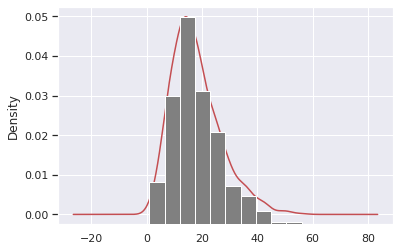

In [21]:
ax1 = msoa_covid.Total_Death.plot.kde(c='r')
ax2= ax1.twinx()
ax2 = msoa_covid.Total_Death.plot.hist(color='grey')
ax2.axis('off')


(-2.41521101444109, 6.440562705176239, 0.0, 329.7)

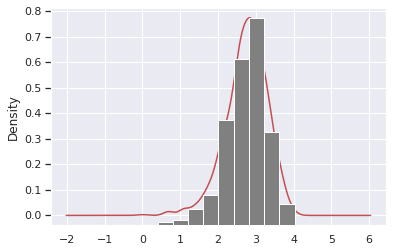

In [22]:
ax1 = msoa_covid1.lntotal.plot.kde(c='r')
ax2= ax1.twinx()
ax2 = msoa_covid1.lntotal.plot.hist(color='grey')
ax2.axis('off')

In [23]:
 msoa_covid["Total_Death"].describe()

count    983.000000
mean      17.878942
std        8.914084
min        1.000000
25%       12.000000
50%       16.000000
75%       23.000000
max       56.000000
Name: Total_Death, dtype: float64

In [24]:
#msoa_covid1.drop([" not English  language households(%)","Black/African/Caribbean/Black British (%)","percentage of obesity(16+)"],axis=1, inplace=True)
msoa_covid1.drop(["Total_Death"],axis=1, inplace=True)

In [25]:
msoa_covid1 = pd.get_dummies(msoa_covid1)
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):

    while True:

        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        vif_df = vif_df.drop('const')
        

        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df

In [26]:
mosa_gdf_census1_new1 = drop_column_using_vif_(msoa_covid1.drop('lntotal', axis=1))


Dropping: Unemployment_Rate


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
regression = sm.OLS(endog=msoa_covid1[['lntotal']],exog=sm.add_constant(mosa_gdf_census1_new1)).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lntotal   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     101.6
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           2.20e-72
Time:                        17:34:43   Log-Likelihood:                -629.02
No. Observations:                 983   AIC:                             1268.
Df Residuals:                     978   BIC:                             1292.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.2349      0.241     21.690      0.000       4.761       5.709
Median_Income          -1.481e-05   1.85e-06     -7.990      0.000   -1.84e-05   -1.12e-05
Economically_active(%)    -0.0216      0.003     -6.215      0.000      -0.028      -0.015
Income_Deprivation         0.0077      0.002      3.443      0.001       0.003       0.012
No_cars_household (%)     -0.0153      0.001    -10.563      0.000      -0.018      -0.012
==============================================================================
Omnibus:                       67.263   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.172
Skew:                          -0.530   Prob(JB):                     3.95e-23
Kurtosis:                       4.182   Cond. No.                     6.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""